In [2]:
from cv2 import aruco
import cv2
import numpy as np
import matplotlib.pyplot as plt
import msgpack as mp
import msgpack_numpy as mpn
import os

from tqdm import tqdm
import csv

In [3]:
_pth = os.getcwd()
_pth = os.path.dirname(_pth)
_parent_folder = "data_for_labelling_aug_1_2023"
_calib_folder_name = "calibration_00"

_folder_name = "mip_sk_30_4_0"
# _folder_name = "board"

_base_pth = os.path.join(_pth,"recorded_data",_parent_folder)

_webcam_calib_folder = os.path.join(_pth,"recorded_data",_parent_folder,_calib_folder_name)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

_webcam_cam_mat

array([[671.25534529,   0.        , 678.00736213],
       [  0.        , 692.23316717, 443.37269229],
       [  0.        ,   0.        ,   1.        ]])

In [ ]:
# Formats: SEGMENTATION, CLASSIFICATION, POSE
DATASET_FORMAT = "SEGMENTATION"

In [4]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = int(_folder_name.split("_")[3])/100
markerSeperation = 0.01

board = aruco.GridBoard(
        size= [1,1],
        markerLength=markerLength,
        markerSeparation=markerSeperation,
        dictionary=ARUCO_DICT)

In [5]:
_video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

default_ids = [12, 88, 89]

data = {"frame_id":[],"marker_ids":[], "corners":[], "tvec":[], "rvec":[]}

counter = 0

for _frame in tqdm(_video_data):

    shape = _frame.shape
    gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

    corners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
        image = gray,
        board = board,
        detectedCorners = corners,
        detectedIds = ids,
        rejectedCorners = rejectedImgPoints,
        cameraMatrix = _webcam_cam_mat,
        distCoeffs = _webcam_dist)

    rotation_vectors, translation_vectors, _ = aruco.estimatePoseSingleMarkers(corners, int(_folder_name.split("_")[3])/100, _webcam_cam_mat, _webcam_dist)

    if ids is None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(None)
        data["corners"].append(None)
        data["tvec"].append(None)
        data["rvec"].append(None)

    if ids is not None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(ids)
        data["corners"].append(corners)
        data["tvec"].append(translation_vectors)
        data["rvec"].append(rotation_vectors)

    counter+=1


_video_file.close()

0it [00:00, ?it/s]

898it [00:08, 109.58it/s]


In [6]:
coordinate = {str(default_ids[0]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              str(default_ids[1]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              str(default_ids[2]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]}}

doesnt_exist = [] # list of ids that doesnt exist in a frame

zero_counter = 0
for i in range(len(data["frame_id"])):
    if data["marker_ids"][i] is not None:
        
        if default_ids[0] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[2])
            
        _zero_counter = 0            
        for j, _m in enumerate(data["marker_ids"][i]):
                
            if _m in default_ids:
                coordinate[str(_m[0])]["x"].append(data["tvec"][i][j][0][0])
                coordinate[str(_m[0])]["y"].append(data["tvec"][i][j][0][1])
                coordinate[str(_m[0])]["z"].append(data["tvec"][i][j][0][2])
                coordinate[str(_m[0])]["rx"].append(data["rvec"][i][j][0][0])
                coordinate[str(_m[0])]["ry"].append(data["rvec"][i][j][0][1])
                coordinate[str(_m[0])]["rz"].append(data["rvec"][i][j][0][2])

                
        for k in doesnt_exist:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)
            
    else:
        for _k in default_ids:
            coordinate[str(_k)]["x"].append(np.nan)
            coordinate[str(_k)]["y"].append(np.nan)
            coordinate[str(_k)]["z"].append(np.nan)
            coordinate[str(_k)]["rx"].append(np.nan)
            coordinate[str(_k)]["ry"].append(np.nan)
            coordinate[str(_k)]["rz"].append(np.nan)
            
    doesnt_exist.clear()

In [7]:
print(len(coordinate["12"]["x"]), len(coordinate["88"]["x"]), len(coordinate["89"]["x"]))

898 898 898


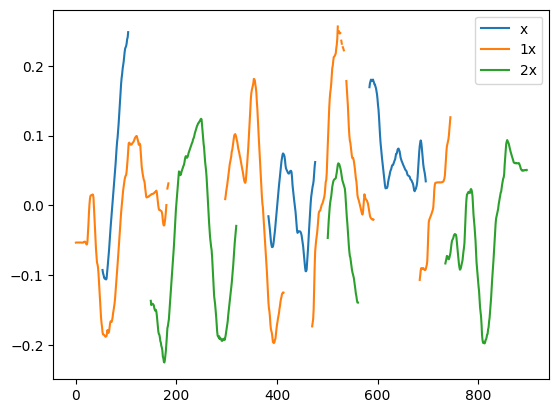

In [8]:
plt.plot(coordinate[str(default_ids[0])]["x"], label="x")
plt.plot(coordinate[str(default_ids[1])]["x"], label="1x")
plt.plot(coordinate[str(default_ids[2])]["x"], label="2x")
plt.legend()

In [27]:
raw_data_pth = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
raw_data_pth = os.path.join(raw_data_pth, 'dataset',"multi_class", "raw_data")
if not os.path.exists(raw_data_pth):
    os.makedirs(os.path.join(raw_data_pth, "images"))
    os.makedirs(os.path.join(raw_data_pth, "labels"))


# based on the coordinate, we can create the labels
# we will create the labels for each frame

_video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

counter = 0

doesnt_exist = [] # list of ids that doesnt exist in a frame

new_ids = []

for _frame in tqdm(_video_data):

    shape = _frame.shape
    height, width, _ = shape
    gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
    markerCorners, ids, rejectedImgPoints = aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)
    new_ids.append(ids)

    markerCorners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
        image = gray,
        board = board,
        detectedCorners = markerCorners,
        detectedIds = ids,
        rejectedCorners = rejectedImgPoints,
        cameraMatrix = _webcam_cam_mat,
        distCoeffs = _webcam_dist)

    if len(markerCorners) == 0:
        counter += 1
        continue

    img_name = f"image_{counter}.png"

    label_name = img_name.split(".")[0]
    label_path = os.path.join(raw_data_pth, "labels", f"{label_name}.txt")
    label_file = open(label_path, "w", newline='')
    label_writer = csv.writer(label_file, delimiter=" ")

    _class_name = ""

    if default_ids[0] not in ids:
        doesnt_exist.append(default_ids[0])
    if default_ids[1] not in ids:
        doesnt_exist.append(default_ids[1])
    if default_ids[2] not in ids:
        doesnt_exist.append(default_ids[2])

    for _inx, _id in enumerate(ids):
        
        if _id in default_ids:
            if _id[0] == default_ids[0]:
                _class_name = "0"
            elif _id[0] == default_ids[1]:
                _class_name = "1"
            elif _id[0] == default_ids[2]:
                _class_name = "2"
            
            _markerCorners = markerCorners[_inx][0]
            bbox_x,bbox_y,bbox_width,bbox_height = cv2.boundingRect(_markerCorners)

            bbox_x = bbox_x / width
            bbox_y = bbox_y / height

            bbox_center_x = bbox_x + bbox_width / (2 * width)
            bbox_center_y = bbox_y + bbox_height / (2 * height)

            bbox_width = bbox_width / width
            bbox_height = bbox_height / height
            
            if DATASET_FORMAT == "SEGMENTATION":
                label_writer.writerow([_class_name,_markerCorners[0][0]/width, _markerCorners[0][1]/height, _markerCorners[1][0]/width, _markerCorners[1][1]/height, _markerCorners[2][0]/width, _markerCorners[2][1]/height, _markerCorners[3][0]/width, _markerCorners[3][1]/height, _markerCorners[0][0]/width, _markerCorners[0][1]/height])
            elif DATASET_FORMAT == "POSE":
                label_writer.writerow([_class_name, bbox_center_x, bbox_center_y, bbox_width, bbox_height,_markerCorners[0][0]/width, _markerCorners[0][1]/height, _markerCorners[1][0]/width, _markerCorners[1][1]/height, _markerCorners[2][0]/width, _markerCorners[2][1]/height, _markerCorners[3][0]/width, _markerCorners[3][1]/height, _markerCorners[0][0]/width, _markerCorners[0][1]/height])

    label_file.close()
    doesnt_exist = []
    # save image
    image_path = os.path.join(raw_data_pth, "images", img_name)
    cv2.imwrite(image_path, _frame)
    counter += 1

_video_file.close()

898it [00:38, 23.47it/s]


In [38]:
# splitting dataset into train and validation and test
data_pth = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_pth = os.path.join(data_pth, 'dataset',"multi_class", "dataset_processed")

images_pth = os.path.join(data_pth, "images")
labels_pth = os.path.join(data_pth, "labels")

if not os.path.exists(images_pth):
    os.makedirs(os.path.join(images_pth, "train"))
    os.makedirs(os.path.join(images_pth, "val"))
    os.makedirs(os.path.join(images_pth, "test"))

if not os.path.exists(labels_pth):
    os.makedirs(os.path.join(labels_pth, "train"))
    os.makedirs(os.path.join(labels_pth, "val"))
    os.makedirs(os.path.join(labels_pth, "test"))
    
    
image_list = os.listdir(os.path.join(raw_data_pth, "images"))

# splitting dataset into train and test
for img_name in tqdm(image_list):
    
    _image_path = os.path.join(raw_data_pth, "images", img_name)
    image = cv2.imread(_image_path)
    
    label_name = img_name.split(".")[0]
    label_path = os.path.join(raw_data_pth, "labels", f"{label_name}.txt")
    label_file = open(label_path, "r")
    label_reader = csv.reader(label_file, delimiter=" ")
    label = list(label_reader)

    label_file.close()
    
    # if int(label[0]) == 0:
    if np.random.rand() < 0.7:
        # save image
        image_path = os.path.join(os.path.join(images_pth, "train"), img_name)
        cv2.imwrite(image_path, image)
        
        label_path = os.path.join(os.path.join(labels_pth, "train"), f"{label_name}.txt")
        label_file = open(label_path, "w")
        label_writer = csv.writer(label_file, delimiter=" ")
        for l in label:
            label_writer.writerow(l)
        label_file.close()
        
    elif np.random.rand() < 0.9 and np.random.rand() > 0.7:
        # save image
        image_path = os.path.join(os.path.join(images_pth, "val"), img_name)
        cv2.imwrite(image_path, image)
        
        label_path = os.path.join(os.path.join(labels_pth, "val"), f"{label_name}.txt")
        label_file = open(label_path, "w")
        label_writer = csv.writer(label_file, delimiter=" ")
        for l in label:
            label_writer.writerow(l)
        label_file.close()
        
    else:
        # save image
        image_path = os.path.join(os.path.join(images_pth, "test"), img_name)
        cv2.imwrite(image_path, image)
        
        label_path = os.path.join(os.path.join(labels_pth, "test"), f"{label_name}.txt")
        label_file = open(label_path, "w")
        label_writer = csv.writer(label_file, delimiter=" ")
        for l in label:
            label_writer.writerow(l)
        label_file.close() 


100%|██████████| 898/898 [00:25<00:00, 34.75it/s]
